# COMP30760 Assignment 1  - Task 2

Name:Opeoluwa Akinola

In this we will collect data for upcoming events from the [Ticketmaster Api](https://developer.ticketmaster.com/products-and-docs/apis/discovery-api/v2) in four different countries(USA,Canada,Great Britain,Ireland)

This notebook covers <b>Task 2 - Data Preparation and Analysis</b>. We will use all of the JSON data collected during Task 1 to perform the analysis process.

In [2]:
import json
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import random
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import scatter_matrix
import seaborn as sns
%matplotlib inline

Key settings, including our list of country with country codes and various appearance settings for plotting later:

In [53]:
# The Countries that we would like to study
# Precision that we'll use for Pandas display
pd.set_option('precision', 2)
# Months in the year
Month=["January","February","March","April","May","June","July","August","September","October","November","December"]
# Colors that we will use in various plots
country_colors = {"USA":"green", "Canada":"darkred", "Great Britain":"orange", "Ireland":"navy"}
#Country information
country_codes ={"US":["USD","USA"],"CA":["CAD","Canada"],"GB":["GBP","Great Britain"],"IE":["EUR","Ireland"]}
# Default font size
fontsize = 13

Directory for data storage

In [54]:
# directory for raw data storage
dir_raw = Path("raw")
# directory for storing clean pre-processed data
dir_data = Path("data")
# make sure it exists
dir_data.mkdir(parents=True, exist_ok=True)


# Data Preprocessing
Before analysing the data, we need to transfrom the data to usable format.

Firstly, we need to find the accurate country raw JSON files with country codes gotten from the data site

In [55]:
#Create dictionary for country files
Countryfiles={}
#Create list for each country
for country in country_codes:
    Countryfiles[country] = []
#check each file in directory 
for fpath in dir_raw.iterdir():
    if fpath.suffix == ".json":
        # parse the filename
        parts = fpath.stem.split("-")
        #check is files correspond to country codes and add to file list and add to file dictionary
        if parts[0] in country_codes:
            Countryfiles[parts[0]].append(fpath)
#Print amount of files found in directory
for country in country_codes:
    print(f"{country}: Found {len(Countryfiles[country])} files")

US: Found 10 files
CA: Found 10 files
GB: Found 10 files
IE: Found 10 files


## Data parsing and merging

Create a method for parsing files in file dictionary to Data frame format

In [56]:
def parse_raw_data(fpath):
    #open JSON file and load 
    fin=open(fpath,"r")
    jdata=fin.read()
    data=json.loads(jdata)
    rows=[]
    #Access useful keys in JSON fle
    for event in data["_embedded"]["events"]:
        row={}
        #Create rows for Data frame and add corresponding values in keys of  JSON files to rows
        #Add exception handling for KeyError
        try:
            row["Event Name"]=event["name"]
            row["ID"]=event["id"]
            row["Event Type"]=event["classifications"][0]["segment"]["name"]
            row["Genre"]=event["classifications"][0]["genre"]["name"]
            row["SubGenre"]=event["classifications"][0]["subGenre"]["name"]
            row["Venue"]=event["_embedded"]["venues"][0]["name"]
            row["City"]=event["_embedded"]["venues"][0]["city"]["name"] 
            row["Country"]=event["_embedded"]["venues"][0]["country"]["name"]
            row["Date"]=event["dates"]["start"]["localDate"]
            row["Ticket type"]=event["priceRanges"][0]["type"]
            row["Currency"]=event["priceRanges"][0]["currency"]
            row["Min Price"]=event["priceRanges"][0]["min"]
            row["Max Price"]=event["priceRanges"][0]["max"]
        except KeyError:
            pass
        rows.append(row)
    #Close file
    fin.close()
    # return back the DataFrame
    return pd.DataFrame(rows)

Create method to merge created dataframe of individual countries into one

In [57]:
def merge_parse_raw_data(files):
    print("Reading and parsing %d JSON data files ..." % len(files))
    df_country_files=[]
    for file in files:
        df_file=parse_raw_data(file)
        df_country_files.append(df_file)
     # concatenate all the DataFrames together into a single frame
    df_country = pd.concat(df_country_files)
    # next we remove duplicate observations based on the ID field
    df_country.drop_duplicates(subset="ID", keep="first", inplace=True)
    # now set the index column to be the Date, which is now unique
    df_country.set_index("ID", inplace=True)
    return df_country

In [58]:
df_countries = {}
#Parse JSON files to Dataframe and merger Dataframes
for country in country_codes:
    print("-- %s" % country)
    df_country = merge_parse_raw_data(Countryfiles[country])
    df_countries[country] = df_country

-- US
Reading and parsing 10 JSON data files ...
-- CA
Reading and parsing 10 JSON data files ...
-- GB
Reading and parsing 10 JSON data files ...
-- IE
Reading and parsing 10 JSON data files ...


## Data verification

Check the format of one of the newly-created country Data Frames:

In [59]:
df_countries['IE'].head(5)

,Event Name,Event Type,Genre,SubGenre,Venue,City,Country,Date,Ticket type,Currency,Min Price,Max Price
ID,,,,,,,,,,,,
G5dFZ9d5jSoLf,Robert Mizzell's Nashville Song Book,Music,Country,Country,Tuar Ard Arts and Enterprise Centre,Co Westmeath,Ireland,2022-03-29,NaN,NaN,NaN,NaN
G5vOZ9ArnldqO,International Friendly - Republic of Ireland V...,Sports,Soccer,Soccer,Aviva Stadium,Dublin,Ireland,2022-03-29,standard,EUR,20.0,90.0
G5vOZ9d1fw0Ug,Shirley Valentine,Arts & Theatre,Theatre,Drama,Gaiety Theatre,Dublin,Ireland,2022-03-29,standard including fees,EUR,22.5,37.7
G5vOZpEQzxZTR,Griff,Music,Rock,Pop,The Academy,Dublin,Ireland,2022-03-29,standard including fees,EUR,19.5,19.5
G5vOZpUEImM38,St. Petersburg Ballet Theatre's Swan Lake,Arts & Theatre,Dance,Dance,Bord Gais Energy Theatre,Dublin,Ireland,2022-03-29,standard,EUR,35.0,119.0


## Data cleaning
Check for missing data in dataframe and handle missing data, by flling missing data and deleting missing data

In [60]:
for country in country_codes:
    print("-- %s" % country)
    missing_counts = df_countries[country].isnull().sum()
    # which coludmns have missing values?
    missing_counts = missing_counts[missing_counts>0]
    if len(missing_counts) == 0:
        print("No missing values found")
    else:
        print(missing_counts)

-- US
Ticket type    352
Currency       352
Min Price      352
Max Price      352
dtype: int64
-- CA
Genre            8
SubGenre        25
Venue           25
City            25
Country         25
Date            25
Ticket type    644
Currency       644
Min Price      644
Max Price      644
dtype: int64
-- GB
Ticket type    668
Currency       668
Min Price      668
Max Price      668
dtype: int64
-- IE
Ticket type    141
Currency       141
Min Price      141
Max Price      141
dtype: int64


Fill 'Currency' values since the currency for a country is all the same and also ticket type.All ticket is a 'standard' type.

Delete  event data without Genre, SubGenre, Venue, City, Country and Date

In [61]:
#fill currency of countries
for country in country_codes:
    df_countries[country]["Currency"]=df_countries[country]["Currency"].fillna(country_codes[country][0])
#fill ticket type and delete events without Genre, SubGenre, Venue, City, Country and Date
for country in country_codes :
    df_countries[country]["Ticket type"]=df_countries[country]["Ticket type"].fillna("Standard")
    df_countries[country]=df_countries[country].dropna(subset=["Genre","SubGenre","Venue","City","Country","Date"])

In dealing with 'min price' and 'max price' missing values, create method to fill the missing values with the average 'min price' and 'max price' of events of the same genre.

In [62]:
def nan_min_max_price_fix(country):
    for idx,value in tqdm(country.iterrows()):
        # get min price
        min_price = str(value['Min Price'])
        # since for every null min price, there is a null max price, we only need to check for one of them to be null
        if min_price == 'nan':
            # check for the genre of that event
            genre = value['Genre']
            # get the avg value of min & max prices for the genre 
            avg_min_price = country[country.Genre==genre]['Min Price'].mean()
            avg_max_price = country[country.Genre==genre]['Max Price'].mean()
            # replace nan with avg min & avg max price
            country.at[idx, 'Min Price'] = avg_min_price 
            country.at[idx, 'Max Price'] = avg_max_price 
            country.dropna(axis=0)
    return country.dropna(subset=["Min Price","Min Price"])

Fill 'min price' and 'max price' missing values for all countries

In [63]:

for country in country_codes:
    df_countries[country]=nan_min_max_price_fix(df_countries[country])

995it [00:01, 556.11it/s] 
970it [00:02, 371.26it/s]
995it [00:03, 323.64it/s]
995it [00:00, 1459.99it/s]


Check for missing values in Dataframe for all countries

In [64]:
for country in country_codes:
    print("-- %s" % country)
    missing_counts = df_countries[country].isnull().sum()
    # which coludmns have missing values?
    missing_counts = missing_counts[missing_counts>0]
    if len(missing_counts) == 0:
        print("No missing values found")
    else:
        print(missing_counts)

-- US
No missing values found
-- CA
No missing values found
-- GB
No missing values found
-- IE
No missing values found


## Data Saving

Write out all of the merged Country DataFrames in JSON format, one file per city. These will represent the 'clean' data that we will use next for our actual data analysis:

In [65]:
for country in country_codes:
    fname = "%s.json" %  country
    out_path = dir_data / fname
    print("Writing %s" % out_path)
    df_countries[country].to_json(out_path, orient="index", indent=4)

Writing data\US.json
Writing data\CA.json
Writing data\GB.json
Writing data\IE.json


# Data Analysis

## Data loading

 We reload the data the we stored prevously into Dataframes

In [66]:
df_countries = {}
for country in country_codes:
    fname = "%s.json" % country
    in_path = dir_data / fname
    df_countries[country] = pd.read_json(in_path, orient="index")
    print("%s: %d rows of data " % 
          (country, len(df_countries[country])))

US: 900 rows of data 
CA: 894 rows of data 
GB: 944 rows of data 
IE: 964 rows of data 


## Ticket price Analysis

Analysis of ticket price for different event types in each country.

Group Dataframe by 'Event Type'

In [67]:
df_group_by_event_type={}
for country in country_codes:
    df_group_by_event_type[country]=df_countries[country].groupby("Event Type")

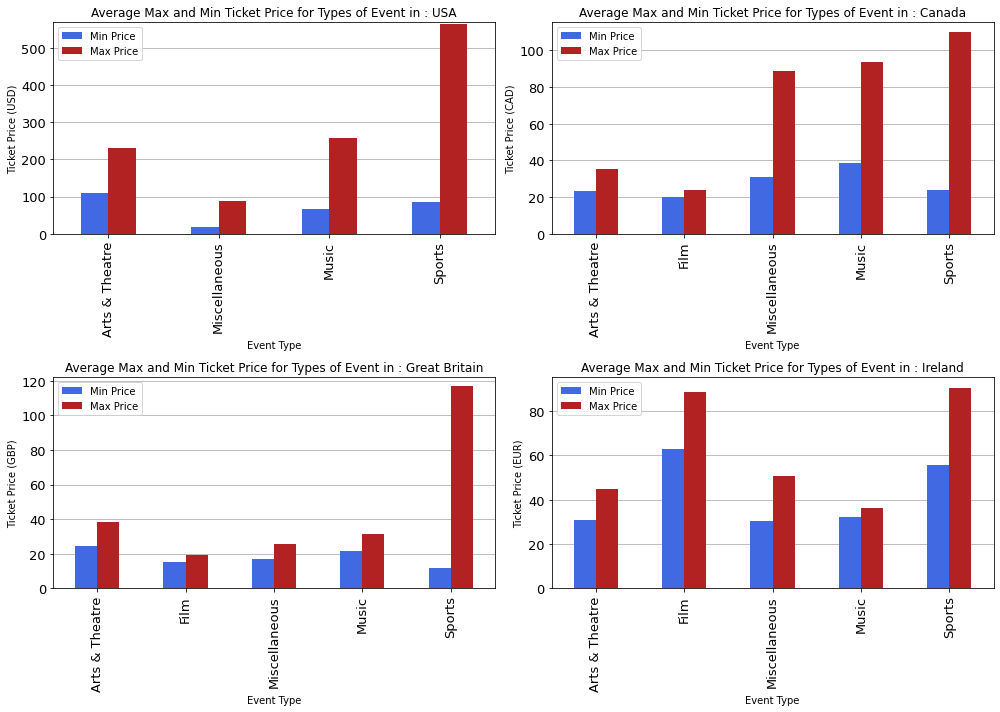

In [68]:
fig = plt.figure(figsize=(14,10))
for i, country in enumerate(country_codes):
    axc = fig.add_subplot(2, 2, i+1)
    #use mean values of all events
    df=df_group_by_event_type[country].mean()
    ax = df.plot(kind="bar",ax=axc, y=['Min Price', 'Max Price'],
        color={ "Min Price": "royalblue", "Max Price": "firebrick"}, fontsize=fontsize, zorder=3)
    ax.set_title("Average Max and Min Ticket Price for Types of Event in : %s" % country_codes[country][1])
    ax.set_ylabel("Ticket Price (%s)" % country_codes[country][0])
    # again make the y-axis ranges consistent
    ax.set_ylim(0,df["Max Price"].max()+5)
    ax.yaxis.grid(True);    
# fix the spacing between plots
fig.tight_layout()

From the above, we can observe that USA invest more into sports than any other type of event.The price difference between the tickets for sports and any other type of event is noticably large.It is the same case in the UK. In Ireland, Film events have simlar pricing range with sports.Sport events are generally the most expensive across all countries.

We can clearly observe that the ticket price for sport events dominate in all countries.

## Event type Analysis
Analysis of the type of events in each country

In [70]:
#create dict to store event type
event_type={}
for country in country_codes:
    event=[]
    #loop through the dataframe for each country and store the event type in dict
    for i in df_countries[country]["Event Type"]:
        if i in event:
            pass
        else:
            event.append(i)
    event_type[country]=event
#create dict to store dataframes 
df_eventcount={}
for country in country_codes:
    counts=[]
    #loop through event type and find match in Dataframe and store number of appearances
    for j in event_type[country]:
        count=0
        for i in df_countries[country]["Event Type"]:
            if j==i:
                count+=1
        #covert count to pecentage
        count=100.00*count/len(df_countries[country]["Event Type"])
        counts.append(count)
    df=pd.DataFrame(counts,event_type[country])
    df.columns=["count"]
    df_eventcount[country]=df


Show share of event type in a bar chart

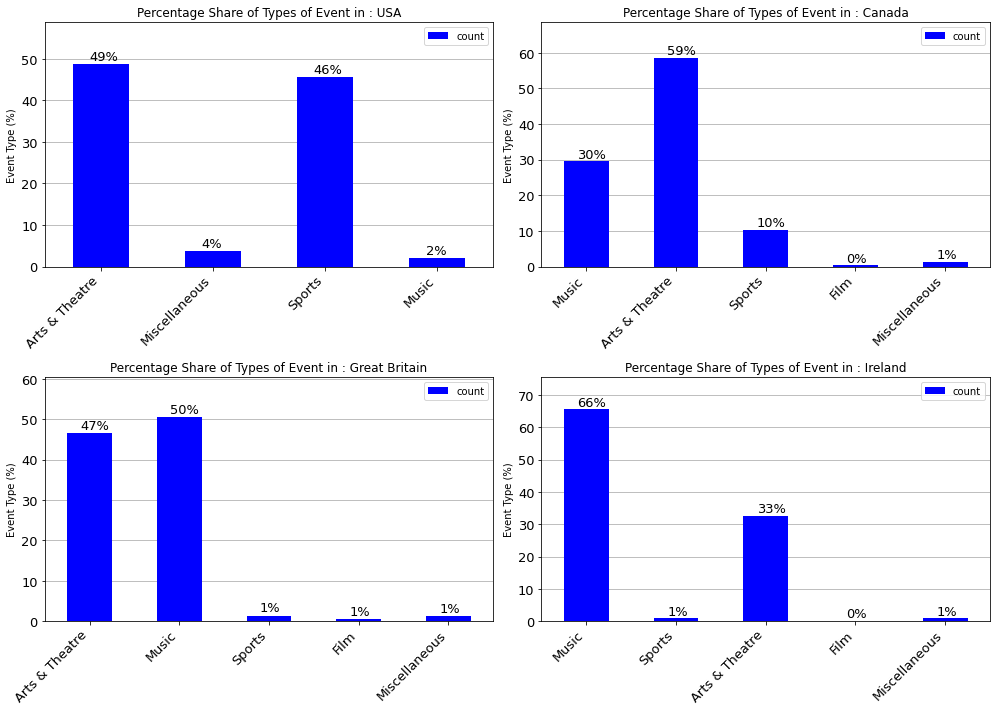

In [71]:
fig = plt.figure(figsize=(14,10))
for i, country in enumerate(country_codes):
    axc = fig.add_subplot(2, 2, i+1)
    df=df_eventcount[country]
    ax = df.plot(kind="bar",ax=axc,
        color="Blue", fontsize=fontsize, zorder=3)
    ax.set_title("Percentage Share of Types of Event in : %s" % country_codes[country][1])
    ax.set_ylabel("Event Type (%)" )
    # again make the y-axis ranges consistent
    ax.set_ylim(0,df["count"].max()+10)
    ax.yaxis.grid(True);    
    # adjust the x-axis label rotation
    plt.xticks(rotation=45, ha='right');
    # add text labels above the bars to show the percentages
    for p in ax.patches:
        b = p.get_bbox()
        val = "{:.0f}%".format(b.y1 + b.y0)        
        ax.annotate(val, ((b.x0 + b.x1)/2 + -0.1, b.y1 + 1.0), fontsize=fontsize)
# fix the spacing between plots
fig.tight_layout()

This can also be expressed in a pie chart as shown below:

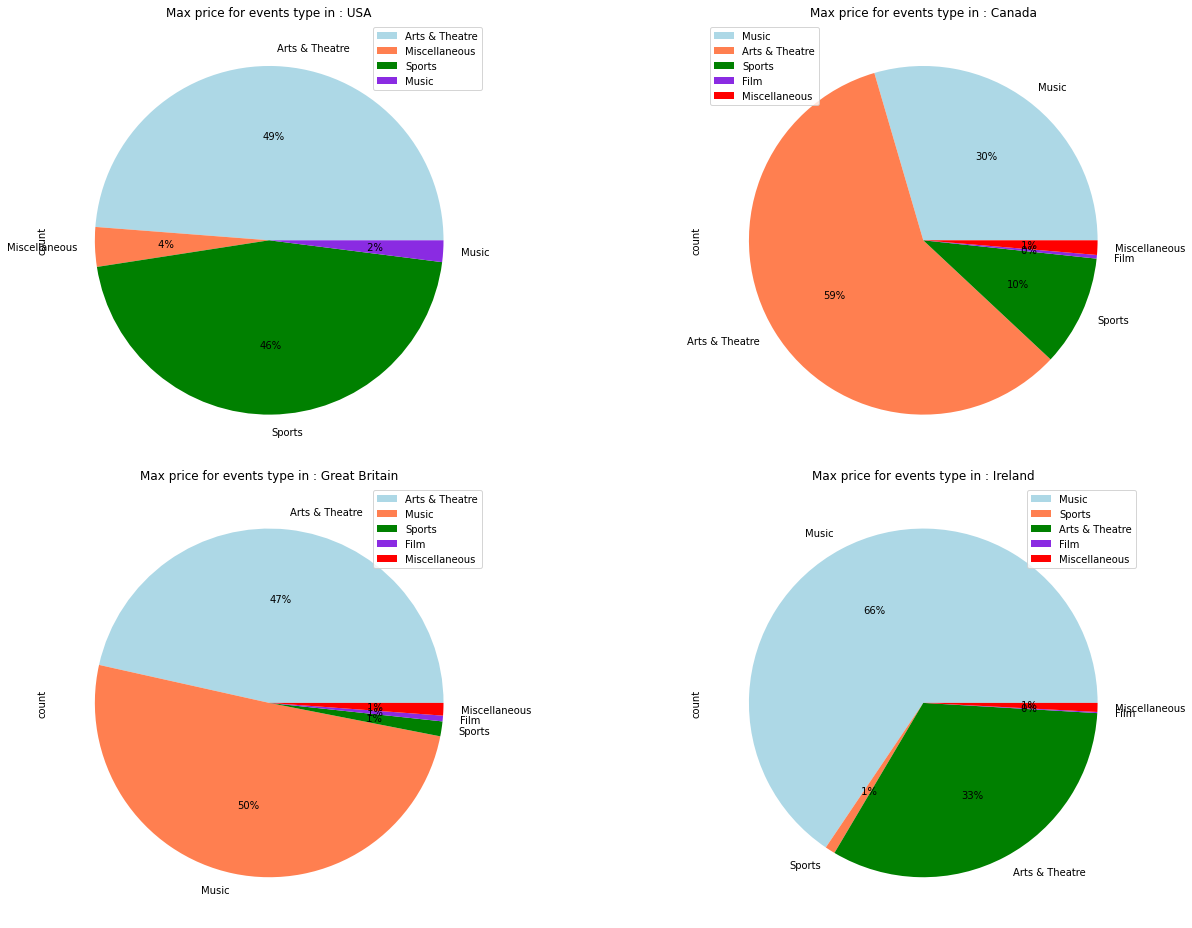

In [108]:
fig = plt.figure(figsize=(20,13))
for i, country in enumerate(country_codes):
    axc = fig.add_subplot(2, 2, i+1)
    #use mean value of all events
    df=df_eventcount[country]
    color_s=["lightblue","coral","green","blueviolet","red"]
    #Plot pie chart using only Max Price
    ax=df.plot(kind="pie",ax=axc,y='count',autopct='%2.0f%%', colors =color_s ,
                 title='Max price for events type in : %s'%country_codes[country][1])
    ax.yaxis.grid(True);
fig.tight_layout()

From the Data we have, there are a lot more Arts & Theatre events and Sports events in the United states than music and other events.There are no film events.In Canada, there is a lot more Art & Theatre events conpared to sports or music.In the UK and Ireland, Music events take the larget share of events.

### Merge Data of  all countries

We create a function to merge all data of all the countries to one Dataframe

In [110]:
def merge_data_by_column(col_name,data):
    columns = {}
    for country in country_codes:
        columns[country_codes[country][1]] = data[country][col_name]
    df_merged = pd.DataFrame(columns)
    return df_merged.fillna(0)

To show comparison of event share in all counties, we merge event type count togethe

In [111]:
df_event_count=merge_data_by_column("count", df_eventcount)
df_event_count

,USA,Canada,Great Britain,Ireland
Arts & Theatre,48.78,58.50,46.50,32.57
Film,0.00,0.34,0.53,0.10
Miscellaneous,3.67,1.34,1.17,0.83
Music,2.00,29.53,50.42,65.56
Sports,45.56,10.29,1.38,0.93


Show comparison in the bar chart below

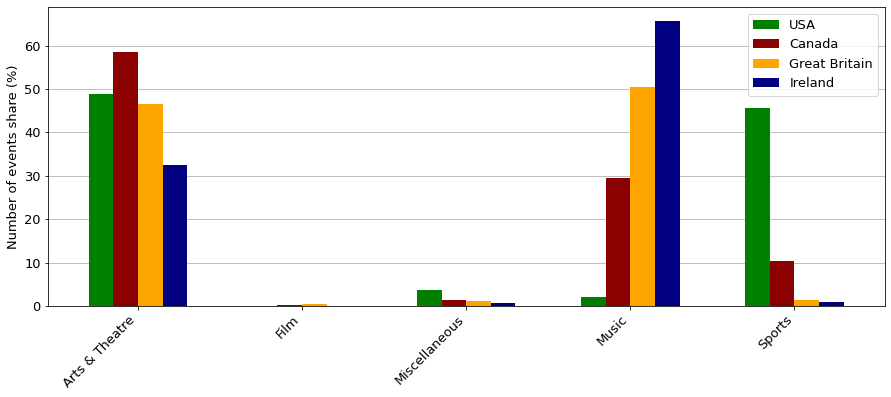

In [112]:
ax = df_event_count.plot.bar(figsize=(15,5.5), width=0.6, fontsize=fontsize, color=country_colors, zorder=3)
ax.legend(fontsize=fontsize)
ax.set_ylabel("Number of events share (%)", fontsize=fontsize)
ax.yaxis.grid(True)
# adjust the x-axis label rotation
plt.xticks(rotation=45, ha='right');

## Genre type Analysis
Create a Dataframe that shows only the percentage share of the event based on Genre type.

In [83]:
#create dict to store event type
genres={}
for country in country_codes:
    genre=[]
    #loop through the dataframe for each country and store the event type in dict
    for i in df_countries[country]["Genre"]:
        if i in genre:
            pass
        else:
            genre.append(i)
    genres[country]=genre
#create dict to store dataframes 
df_genrecount={}
for country in country_codes:
    counts=[]
    #loop through event type and find match in Dataframe ans tore number of appearances
    for j in genres[country]:
        count=0
        for i in df_countries[country]["Genre"]:
            if j==i:
                count+=1
        #covert count to pecentage
        count=100.00*count/len(df_countries[country]["Genre"])
        counts.append(count)
    df=pd.DataFrame(counts,genres[country])
    df.columns=["count"]
    df_genrecount[country]=df

Plot the percentage share of genres in each country

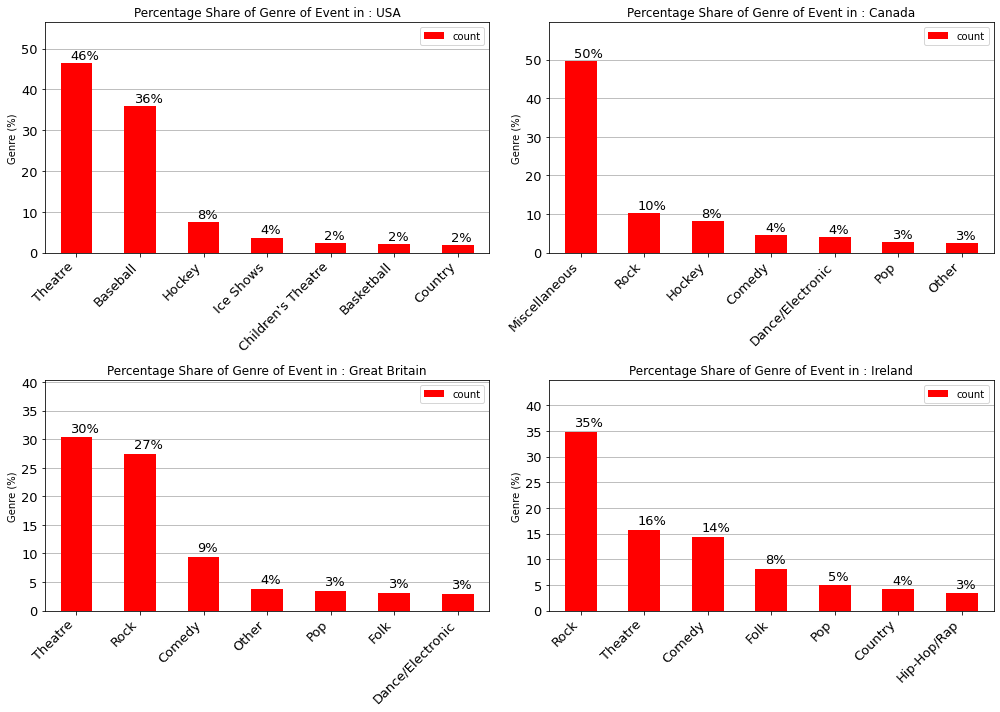

In [84]:
fig = plt.figure(figsize=(14,10))
for i, country in enumerate(country_codes):
    axc = fig.add_subplot(2, 2, i+1)
    #Put in descendnig order
    df=df_genrecount[country].sort_values(by=["count"],ascending=False)
    #Limit the genres to 7 to make the plot 
    df=df.head(7)
    ax = df.plot(kind="bar",ax=axc,
        color="Red", fontsize=fontsize, zorder=3)
    ax.set_title("Percentage Share of Genre of Event in : %s" % country_codes[country][1])
    ax.set_ylabel("Genre (%)" )
    # again make the y-axis ranges consistent
    ax.set_ylim(0,df["count"].max()+10)
    ax.yaxis.grid(True);    
    # adjust the x-axis label rotation
    plt.xticks(rotation=45, ha='right');
    # add text labels above the bars to show the percentages
    for p in ax.patches:
        b = p.get_bbox()
        val = "{:.0f}%".format(b.y1 + b.y0)        
        ax.annotate(val, ((b.x0 + b.x1)/2 + -0.1, b.y1 + 1.0), fontsize=fontsize)
# fix the spacing between plots
fig.tight_layout()

From the above, we observe that in Great britain and the United States, there are more theatre events. While in Canada, there are more Miscallaneous events (These events include:kids shows, carnivals, amusement parks etc).In ireland, there are a lot of Rock concerts events coming up.Similar to this is Great Briatin.A considerable amount of Rock concerts.

The amount of plotted genres were restricted due to spacing of the plot and for easer readability.However, below, we put them all in a table sorted by country.

In [114]:
df_genre_count=merge_data_by_column("count",df_genrecount)
df_genre_count

,USA,Canada,Great Britain,Ireland
Action/Adventure,0.00,0.00,0.00,0.10
Alternative,0.00,1.68,0.00,0.00
Baseball,35.89,0.00,0.00,0.00
Basketball,2.11,0.67,0.00,0.00
Blues,0.00,0.56,1.06,0.21
Boxing,0.00,0.22,0.00,0.00
Chanson Francaise,0.00,0.22,0.00,0.00
Children's Music,0.00,0.00,0.11,0.00
Children's Theatre,2.33,0.00,0.00,0.83
Circus & Specialty Acts,0.00,0.11,0.00,0.00


## Event Date Analysis

From our given data, we decide to goup events into month the events will take place.

We use DateTimeIndex(dt) to access separate date time into months.

we then sort them from the start of the year to the end.

In [97]:
for country in country_codes:
    #Convert to Datetime format and sort events according to date
    df_countries[country]["Date"]=pd.to_datetime(df_countries[country]["Date"])
    df_countries[country]= df_countries[country].sort_values(by="Date")

Next we count each events happening in each month of the year and create a new Dataframe for each country

In [78]:
df_event_per_count={}
for country in country_codes:
    counts=[]
    for i in range(1,13):
        # count number of events in specified month number
        filtered_df = df_countries[country].loc[df_countries[country]['Date'].dt.month == i]
        counts.append(len(filtered_df))
    df=pd.DataFrame(counts,Month)
    df.columns=["count"]
    df_event_per_count[country]=df

Merge all country's monthly event count.

In [119]:
df_monthly_event_count=merge_data_by_column("count",df_event_per_count)
df_monthly_event_count

,USA,Canada,Great Britain,Ireland
January,0,0,0,0
February,0,0,5,0
March,107,869,939,30
April,252,11,0,457
May,159,11,0,432
June,171,2,0,45
July,105,1,0,0
August,66,0,0,0
September,36,0,0,0
October,2,0,0,0


Show comparison in the bar chart below

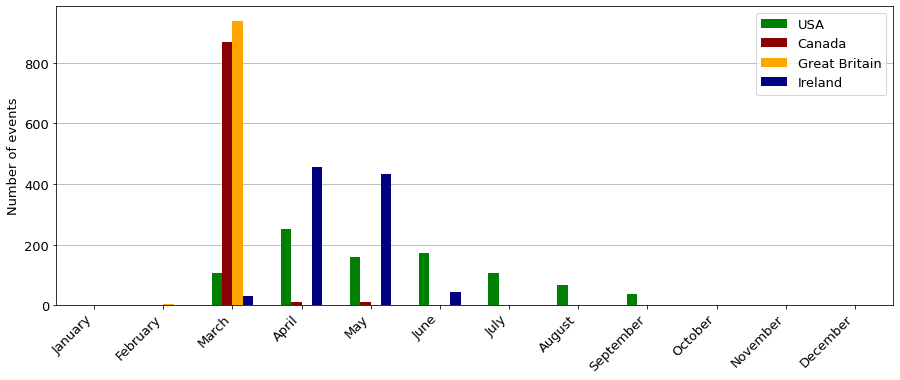

In [120]:
ax = df_monthly_event_count.plot.bar(figsize=(15,5.5), width=0.6, fontsize=fontsize, color=country_colors, zorder=3)
ax.legend(fontsize=fontsize)
ax.set_ylabel("Number of events", fontsize=fontsize)
ax.yaxis.grid(True)
# adjust the x-axis label rotation
plt.xticks(rotation=45, ha='right');

Alternatively, to make this a little clearer, using a heatmap representation to display the full set of percentages for the different text descriptions:

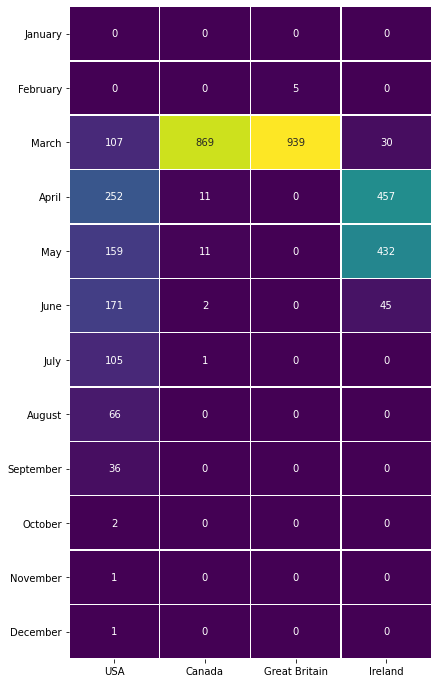

In [85]:
# create a color palettte
cmap = sns.color_palette("viridis", as_cmap=True)
# display the heatmap, with number of events
f, ax = plt.subplots(figsize=(6.5,12))
h = sns.heatmap(monthly_event_count, square=False, cbar=False,
            annot=True, fmt='.0f', cmap=cmap, linewidths=0.5, vmin=0)

March seems like a very busy month in Canada and Great Britain.From our given data, only USA has a larger spread of events for the whole year.
This analysis could be used as an itenery guide for tourst planning to visit thses countries at certain times of the year.

## Correlation between countries

We want to observe correlation between countries.

We will define a single fuction which computes the pairwise Pearson correlations between the columns (i.e. countries) and displays this as a 'heatmap' visualisation:

In [87]:
import numpy as np
def plot_heatmap(title, df_in, figsize=(5.5, 5)):
    df_corr = df_in.corr()
    # create a color palettte
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # display the heatmap
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df_corr, square=True, cbar=False,
                annot=True, cmap=cmap, linewidths=0.5, vmin=-1)
    ax.set_title(title)

First we find event type correllation

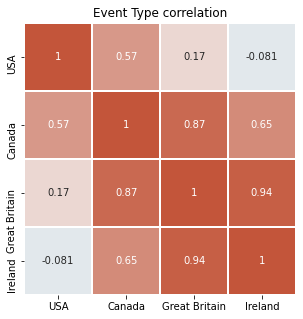

In [113]:
plot_heatmap("Event Type correlation",df_event_count)

The is a strong correllation betwwen type pf events in Great Brtain and Ireland.This is expected because it could be because they have similar culture or similar taste or they are the only two fully English speaking countries in Europe.

Also,there is a fair correllation between Canada and Great Britain, and Canada and Ireland.This was not expected as they have different culture and a kilometers away from each other.

A more expected correlation is between Canda and USA

Next we find Genre Type correllation

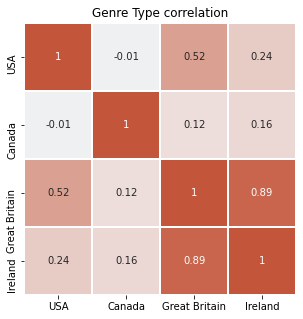

In [117]:
plot_heatmap("Genre Type correlation",df_genre_count)

Again, strong correllation between Great Britain and Ireland.The culture and preferences and indeed similar.

Next we find monthly event Type correllation

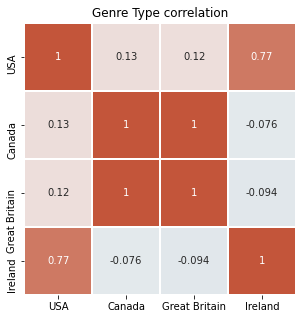

In [122]:
plot_heatmap("Genre Type correlation",df_monthly_event_count)

There is perfect correlation between time line of events betwwen Canada and Great Britain.Also strong correlation betwwen Ireland and USA.This result is subjective only to the data available to us. 

# Conclusion

In this asssignment, we looked at the analysis of event from four countries: USA, Canada, Ireland, Great Britain.Focus was on Event Type, Genre Type, Event Date and Ticket Prices.Events in Ireland and Great Britain are similar in Type and Genre as we might expect.Canada and USA are failry similar too in types of Event and Genre.

As is expected, Sport event tickets are the most expensive in all four countries.

we also found that Theatre event are a lot more than expected.There is a fair amount of Theate and Arts event in Canada, USA and Great Britain.

Challenges faced include:
<ul>
  <li>Limited amaount of data</li>
  <li>Not enough Numerical data for more complex numerical analysis</li>
  <li>A lot os mssinf values that had to be removed.Reduced the amount of data neede for analysis greatly.</li>
</ul>

For future work,these could be considered for future analysis:
<ul>
  <li>Analysis could be extended to far more contries to get greater spread of analysis</li>
  <li>More data would be useful expecially with the tmeline of events.Could show seasonality in events even to multiple years.   </li>
  <li>Analysis concerning the venues of event will be considered.</li>
</ul>